In [1]:
import torch
import pandas as pd
import numpy as np
import random
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from func import loadMS_class,loadTS

In [10]:
def splitTs():    
    df = pd.read_excel("../data/tensile.xlsx")
    y = df["E (GPa)"].values
    col=['Ti', 'Nb', 'Zr', 'Sn', 'Mo', 'Ta']
    x = df[col].values
    del df
    x_tr,x_te,y_tr,y_te= train_test_split(x, y, test_size=0.2,random_state=0)
    mean = np.mean(x_tr, axis = 0) 
    std = np.std(x_tr, axis = 0)
    for i in range(x_tr.shape[0]):
        for j in range(x_tr.shape[1]):
            if not std[j] == 0 :
                x_tr[i][j] = (x_tr[i][j]- mean[j]) / std[j]
    for i in range(x_te.shape[0]):
        for j in range(x_te.shape[1]):
            if not std[j] == 0 :
                x_te[i][j] = (x_te[i][j]- mean[j]) / std[j]

    x_tr = torch.tensor(x_tr).float()
    x_te = torch.tensor(x_te).float()
    y_tr = torch.unsqueeze(torch.tensor(y_tr).float(),dim=1)
    y_te = torch.unsqueeze(torch.tensor(y_te).float(),dim=1)
    return x_tr,x_te,y_tr,y_te
def splitMs():
    df = pd.read_excel("../data/stability.xlsx")
    col=['Ti', 'Nb', 'Zr', 'Sn', 'Mo', 'Ta']
    x = df[col].values
    y = df["stability"].values
    x_tr,x_te,y_tr,y_te= train_test_split(x, y, test_size=0.2, random_state=0)
    mean = np.mean(x_tr, axis = 0) 
    std = np.std(x_tr, axis = 0)
    for i in range(x_tr.shape[0]):
        for j in range(x_tr.shape[1]):
            if not std[j] == 0 :
                x_tr[i][j] = (x_tr[i][j]- mean[j]) / std[j]
    for i in range(x_te.shape[0]):
        for j in range(x_te.shape[1]):
            if not std[j] == 0 :
                x_te[i][j] = (x_te[i][j]- mean[j]) / std[j]

    x_tr = torch.tensor(x_tr).float()
    x_te = torch.tensor(x_te).float()
    y_tr = torch.unsqueeze(torch.tensor(y_tr).float(),dim=1)
    y_te = torch.unsqueeze(torch.tensor(y_te).float(),dim=1)
    return x_tr,x_te,y_tr,y_te
def accuracy(pred,label):
    return np.mean((pred.detach().numpy()>0.5) == label.detach().numpy())
def train(s,net,lr,TsDataset,MsDataset,epoch=3000,reg=True,name=""):
    opt = torch.optim.Adam(net.parameters(),lr=lr)
    torch.manual_seed(s)
    for i in range(epoch):
        if reg:
            x_tr,x_te,y_tr,y_te = TsDataset
            mse_tr = lossMSE(net(x_tr),y_tr)
            mse_te = lossMSE(net(x_te.detach()),y_te.detach()).item()
            loss = mse_tr
            if i==0:
                best_mse = mse_te
            else:
                if mse_te < best_mse:
                    best_mse = mse_te
                    if mse_te < 100:
                        torch.save(net,"../single/reg/%.2f_%d_%d_%s.pkl"%(mse_te,s,i,name))                                
        else:
            x_tr,x_te,y_tr,y_te = MsDataset
            loss = lossBCE(sig(net(x_tr)),y_tr)
            acc_tr = accuracy(sig(net(x_tr.detach())),y_tr.detach()).item()
            acc_te = accuracy(sig(net(x_te.detach())),y_te.detach()).item()
            if i == 0:
                best_acc = acc_te
            else:
                if acc_te > best_acc:
                    best_acc = acc_te
                    if acc_te > 0.85:
                        torch.save(net,"../single/cls/%.2f_%d_%d_%s.pkl"%(acc_te,s,i,name))
#             print(acc_te)
        opt.zero_grad()
        loss.backward()
        opt.step()
#         print("%.2f %.2f %.2f %.2f"%(mse_tr,mse_te,acc_tr,acc_te))
        
                

In [11]:
TsDataset = splitTs()
MsDataset = splitMs()
m_list=np.arange(5,31)
lr_list=np.arange(0.01,0.11,0.01)
act_list=[nn.PReLU(),nn.CELU(),nn.SELU(),nn.Softplus(),nn.ReLU()]
lossMSE = nn.MSELoss()
lossBCE = nn.BCELoss()
sig = nn.Sigmoid()
f = TsDataset[0].shape[1]
for reg in [False]:
    for act in act_list:
        for m in m_list:
            for lr in lr_list:            
                net=nn.Sequential(
                            nn.Linear(f, m),
                            act,
                            nn.Linear(m, 1))
                train(0,net,lr,TsDataset,MsDataset,epoch=2000,reg=reg,name="%s_%d_%.2f"%(act,m,lr))        
    
    
    
    
    
    
    

In [12]:
TsDataset = splitTs()
MsDataset = splitMs()
m_list=np.arange(5,31)
lr_list=np.arange(0.01,0.11,0.01)
act_list=[nn.PReLU(),nn.CELU(),nn.SELU(),nn.Softplus(),nn.ReLU()]
lossMSE = nn.MSELoss()
lossBCE = nn.BCELoss()
sig = nn.Sigmoid()
f = TsDataset[0].shape[1]
reg = True
for s in range(1,10):
    for act in act_list:
        for m in m_list:
            for lr in lr_list:
                
                net=nn.Sequential(
                            nn.Linear(f, m),
                            act,
                            nn.Linear(m, 1))
                train(s,net,lr,TsDataset,MsDataset,epoch=2000,reg=reg,name="%s_%d_%.2f"%(act,m,lr))        
    
    
    
    
    
    
    

KeyboardInterrupt: 

In [15]:
net = torch.load("../models/40.50_0.92_0_1913_10_CELU(alpha=1.0)_26_0.06.pkl")
x_tr,x_te,y_tr,y_te = TsDataset
lossMSE(net(x_te)[:,0:1],y_te)

tensor(40.4983, grad_fn=<MseLossBackward>)

In [33]:
multi = model(x_te)[:,0].detach().numpy()

In [34]:
svr = np.load("svr.npy")
xgb = np.load("xgb.npy")

In [45]:
mean = np.mean(np.array([multi,svr,xgb]),axis=0)
std = np.std(np.array([multi,svr,xgb]),axis=0)

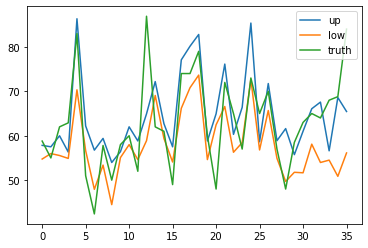

In [47]:
import matplotlib.pyplot as plt
p1,=plt.plot(np.arange(len(mean)),mean+std)
p2,=plt.plot(np.arange(len(mean)),mean-std)
p3,=plt.plot(np.arange(len(mean)),y_te.detach().numpy().reshape(-1))
plt.legend([p1,p2,p3],["up","low","truth"])